# Analysis of IMB

This notebook performs data analysis of the csv files created by running the IMB benchmark

In [12]:
import csv

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

In [14]:
results = {
    "Cloud_IMB":[],
    "SCARF_IMB":[]
}

for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        latencyIndex = headers.index("Latency")  #
        bandwidthIndex = headers.index("0")  # after hear, all are the bandwidths
        thisMessageSizes = [int(el) for el in headers[bandwidthIndex + 1:]]
        try:
            if messageSizes != [int(el) for el in headers[bandwidthIndex + 1:]]:
                raise ValueError("Different message sizes")
        except NameError: # if messageSizes hasn't been set yet
            messageSizes = thisMessageSizes
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            thisRow["Bandwidths"] = [float(el) for el in row[bandwidthIndex + 1:]]
            thisRow["maxBandwidths"] = max(thisRow["Bandwidths"])
            thisRow["meanBandwidths"] = sum(thisRow["Bandwidths"]) / len(thisRow["Bandwidths"])
            results[dataName].append(thisRow)
print("Message Sizes:")
print(messageSizes)
print()
for dataName in results:
    print(dataName)
    print("1st latency:        {}".format(results[dataName][0]["Latency"]))
    print("max bandwidth:      {}".format(max(test["maxBandwidths"] for test in results[dataName])))
    print("1st bandwidths(10): {}".format(results[dataName][0]["Bandwidths"][0:10]))
    print("Headers:            {}".format(results[dataName][0].keys()))
    print()
        

Message Sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

SCARF_IMB
1st latency:        0.23
max bandwidth:      9149.72
1st bandwidths(10): [3.98, 7.96, 15.96, 31.86, 63.71, 126.61, 261.36, 311.81, 597.61, 1037.75]
Headers:            dict_keys(['8', 'maxBandwidths', 'Max Processes', '1048576', '8388608', '32', '1', 'Max Swap (MB)', 'Protocols Seen', '4096', '2097152', 'Delta Memory (MB)', 'Exclusive', '16', 'CPU time (sec.)', 'Latency', '16777216', '65536', '4194304', 'File Name', '32768', 'Total Requested Memory (MB)', '1024', '128', '64', 'Max Memory (MB)', 'Turnaround time (sec.)', '8192', '4', '2', '256', 'meanBandwidths', 'Number of Hosts', 'Hosts Used', 'Max Threads', 'Bandwidths', '131072', 'Average Memory (MB)', '524288', '0', 'Run time (sec.)', '262144', '2048', '512', 'Host Groups', '16384'])

Cloud_IMB
1st latency:        0.27
max bandwidth:      7717.49
1st ban

In [15]:
import datetime

# Do cloud dates:
for result in results["Cloud_IMB"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF uppercase and map 'X-X' -> 'X'
for result in results["SCARF_IMB"]:
    result["Host Groups"] = result["Host Groups"].split("-")[0].upper()
    

['SHM', 'SHM-IBV', 'SHM-TCP']


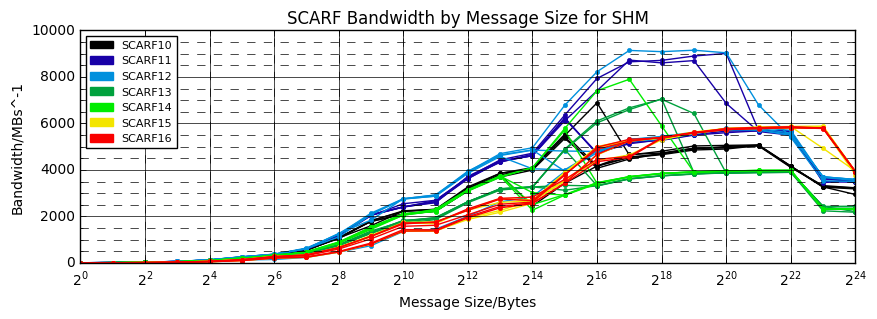

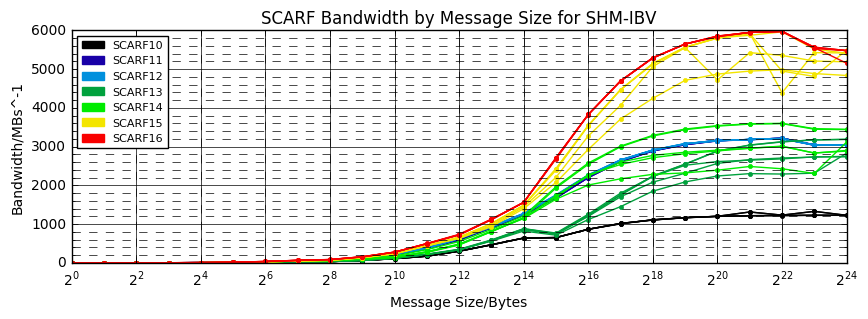

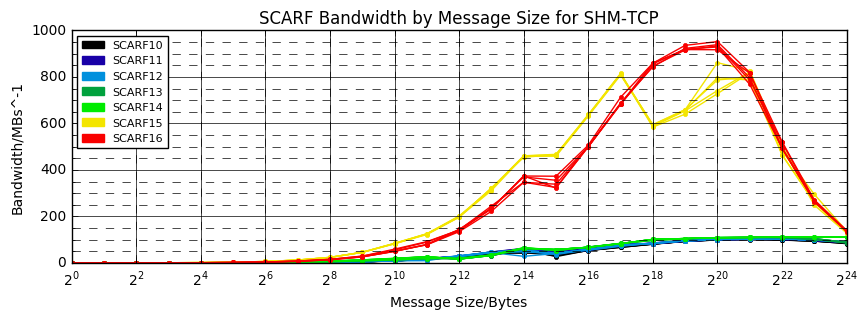

In [16]:
def plotScarfBandwidth():
    protocols = sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"]))
    print(protocols)
    for prot in protocols:
        res = [row for row in results["SCARF_IMB"] if row["Protocols Seen"] == prot]
        hostgroups = sorted(set(row["Host Groups"] for row in res))
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        for index, hostgroup in enumerate(hostgroups):
            clr = clrMap(index / len(hostgroups))
            legendHandles.append(mpatches.Patch(color=clr, label=hostgroup))
        for index, row in enumerate(sorted(res, key=lambda el: el["File Name"])):
            band = row["Bandwidths"]
            clr = clrMap(hostgroups.index(row["Host Groups"]) / len(hostgroups))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            nodeNumbers = ",".join(re.findall("cn\d+", row["Hosts Used"]))
            # legendHandles.append(mpatches.Patch(color=clr, label=nodeNumbers))
        plt.legend(handles=legendHandles, loc=2, ncol=1, fontsize=8)
        plt.rcParams["figure.figsize"] = (10, 3)
        plt.xscale("log", basex=2)
        plt.title("SCARF Bandwidth by Message Size for {}".format(prot))
        plt.xlabel("Message Size/Bytes")
        plt.ylabel("Bandwidth/MBs^-1")
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotScarfBandwidth()


['1', '2']


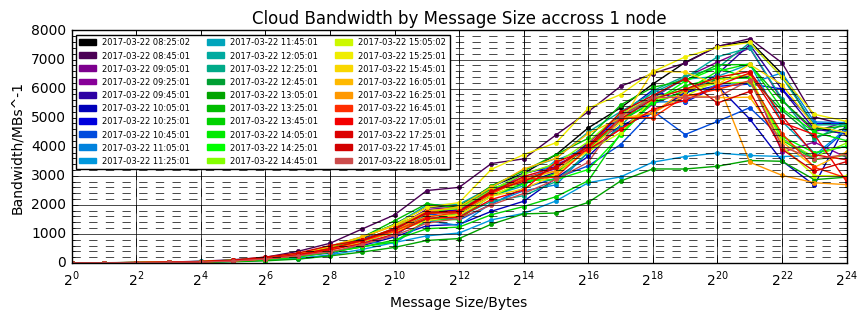

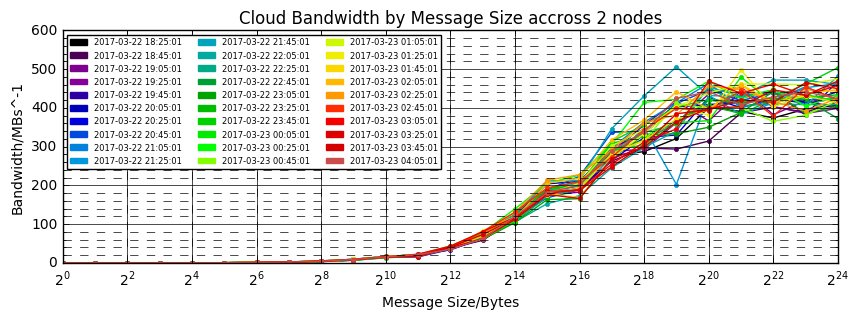

In [17]:
def plotCloudBandwidth():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    for numHosts in numHostsSet:
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        for index, row in enumerate(sorted(res, key=lambda el: el["Date Run"])):  # sort by date run
            band = row["Bandwidths"]
            clr = clrMap(index / len(res))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            legendHandles.append(mpatches.Patch(color=clr, label=row["Date Run"]))
        plt.legend(handles=legendHandles, loc=2, ncol=3, fontsize=6)
        plt.rcParams["figure.figsize"] = (10, 3)
        plt.xscale("log", basex=2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Cloud Bandwidth by Message Size accross " + titleEnd)
        plt.xlabel("Message Size/Bytes")
        plt.ylabel("Bandwidth/MBs^-1")
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotCloudBandwidth()

['1', '2']


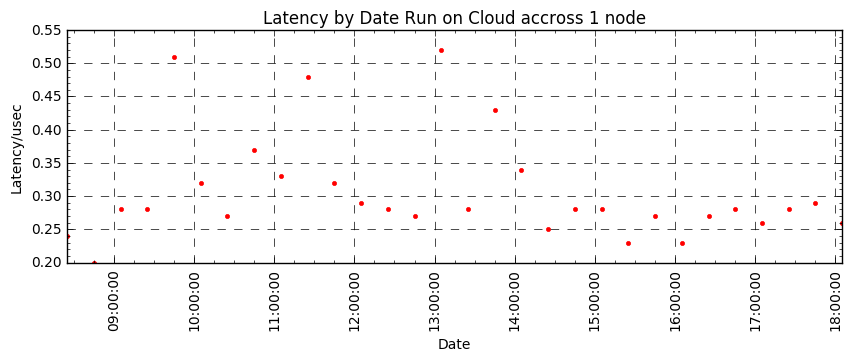

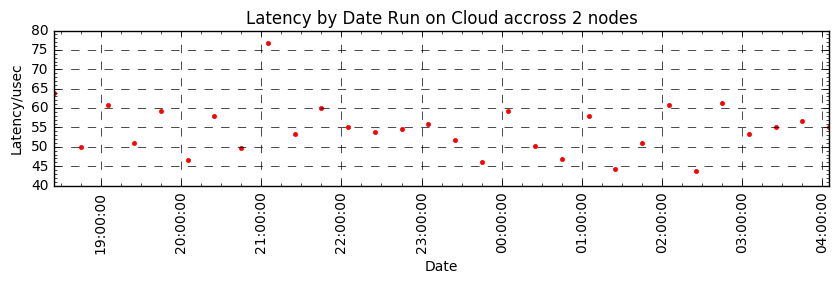

In [7]:
def plotCloudLatencies():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    
    for index, numHosts in enumerate(numHostsSet):
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        plt.plot([row["Date Run"] for row in res], 
                 [row["Latency"] for row in res], "r.")
        plt.xticks(rotation='vertical')
        plt.rcParams["figure.figsize"] = (10,2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Latency by Date Run on Cloud accross " + titleEnd)
        plt.ylabel("Latency/usec")
        plt.xlabel("Date")
        #plt.grid(True, which="minor", linestyle="-")
        plt.grid(True, which="major", linestyle="--")
        plt.minorticks_on()
        plt.show()

plotCloudLatencies()

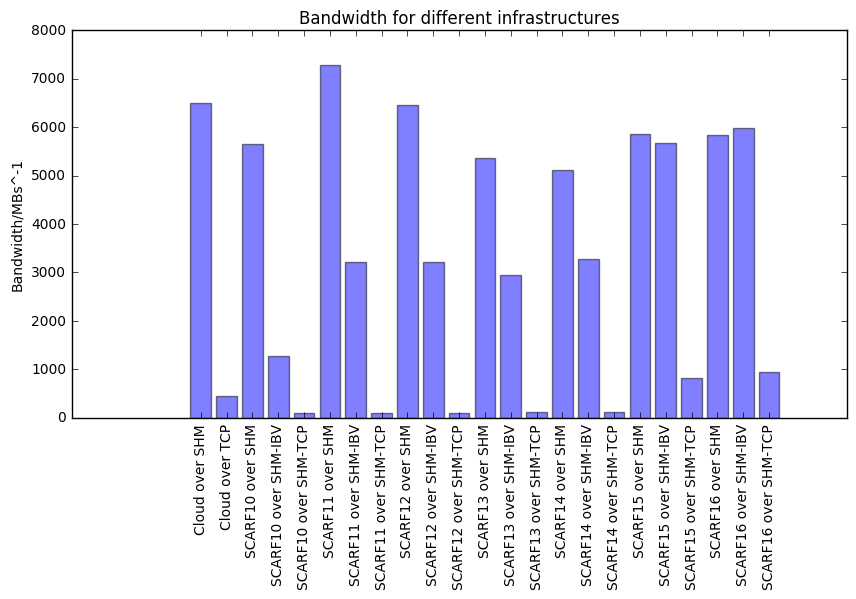

In [23]:
def plotMaxBandwidths():

    # Add the cloud split into number of hosts
    yValues = [max(row["maxBandwidths"] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"), 
               max(row["maxBandwidths"] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2")]
    xValues = ["Cloud over SHM", "Cloud over TCP"]
    
    # Add the SCARF split into host group and number of hosts
    
    for hostgroup in sorted(set(row["Host Groups"] for row in results["SCARF_IMB"])):
        for prot in sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"])):
            xValues += ["{} over {}".format(hostgroup, prot)]
            yValues += [max(row["maxBandwidths"] for row in results["SCARF_IMB"] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"])]
    
    

    plt.bar(np.arange(len(yValues)), yValues, align='center', alpha=0.5)
    
    plt.xticks(np.arange(len(yValues)), xValues, rotation="vertical")
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Bandwidth/MBs^-1")
    plt.title('Bandwidth for different infrastructures')

    plt.show()
    


plotMaxBandwidths()

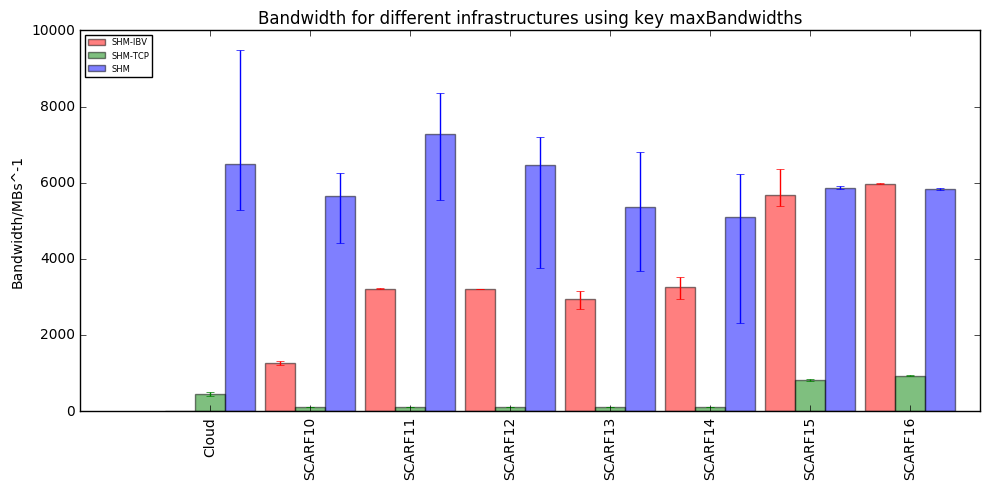

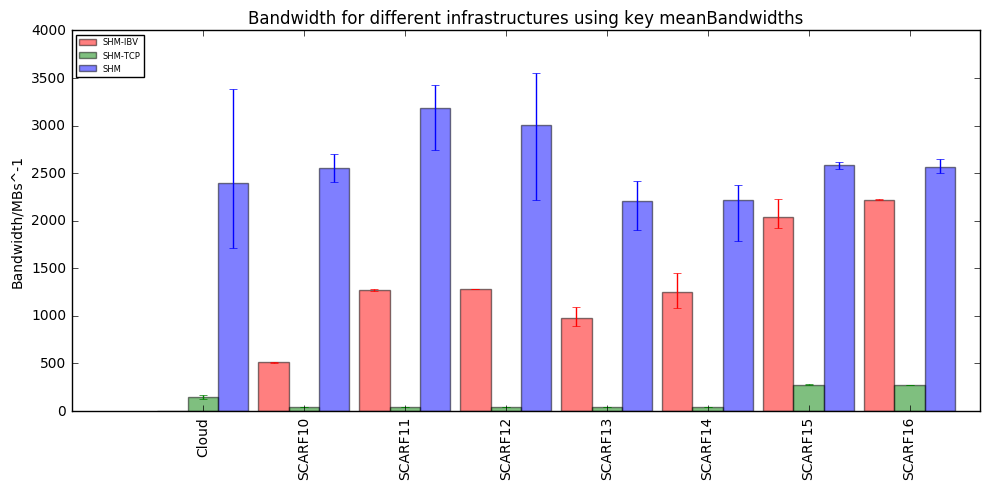

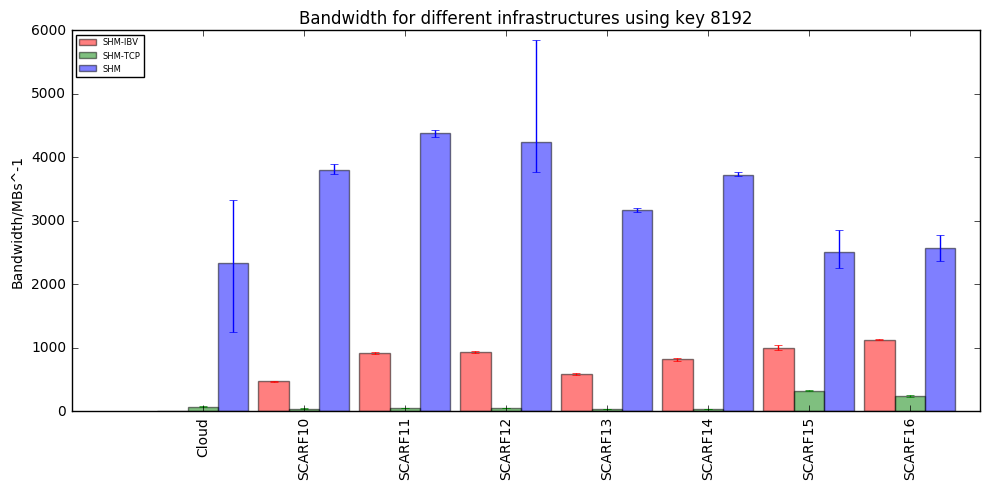

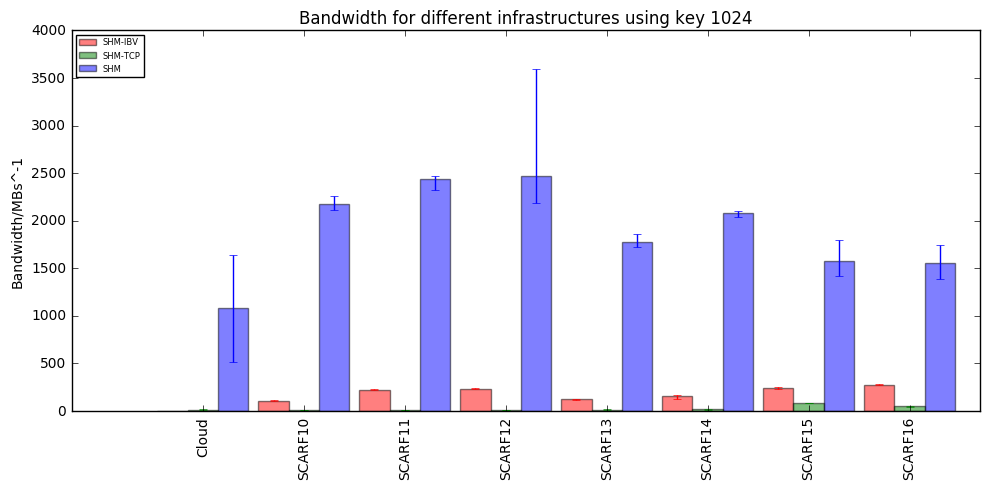

In [34]:
def plotBandwidths(BW_KEY="maxBandwidths"):
    
    
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues = ["Cloud"]
    
    
    # Add the SCARF split into host group and number of hosts
    
    for hostgroup in sorted(set(row["Host Groups"] for row in results["SCARF_IMB"])):
        xValues += [hostgroup]
        for prot in sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"])):
            addBarData([row[BW_KEY] for row in results["SCARF_IMB"] 
                        if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]], prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.3
    clrs = ["r", "g", "b"]
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yValues[label], bar_width, align='center', color=clrs[i], alpha=0.5, label=label)
        plt.errorbar(index + i * bar_width, yValues[label], yerr=[yTopError[label], yBottomError[label]], linestyle=" ", 
                     color=clrs[i])
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Bandwidth/MBs^-1")
    # plt.yscale("log")
    plt.title('Bandwidth for different infrastructures using key {}'.format(BW_KEY))

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()
    


plotBandwidths()
plotBandwidths(BW_KEY="meanBandwidths")
plotBandwidths(BW_KEY="8192")
plotBandwidths(BW_KEY="1024")

In [22]:
def plotLatenciesBandwidths(BW_KEY="maxBandwidths"):
    
    
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues = ["Cloud"]
    
    
    # Add the SCARF split into host group and number of hosts
    
    for hostgroup in sorted(set(row["Host Groups"] for row in results["SCARF_IMB"])):
        xValues += [hostgroup]
        for prot in sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"])):
            addBarData([row[BW_KEY] for row in results["SCARF_IMB"] 
                        if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]], prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.3
    clrs = ["r", "g", "b"]
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yValues[label], bar_width, align='center', color=clrs[i], alpha=0.5, label=label)
        plt.errorbar(index + i * bar_width, yValues[label], yerr=[yTopError[label], yBottomError[label]], linestyle=" ", 
                     color=clrs[i])
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.ylabel("Bandwidth/MBs^-1")
    # plt.yscale("log")
    plt.title('Bandwidth for different infrastructures using key {}'.format(BW_KEY))

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()

506.17

In [ ]:
len()